In [ ]:
# feature engineering
# Conny Lin | June 14, 2020

In [1]:
# updated June 14, 2020
# computer dependent local variable settings 
import socket, os
# check which computer this code is running on
hostname = socket.gethostname().split('.')[0]
# set local path settings based on computer host
if hostname == 'PFC':
    pylibrary = ['/Users/connylin/Dropbox/Code/proj/']
    pCapstone = '/Users/connylin/Dropbox/CA/ED _20200119 Brain Station Data Science Diploma/Capstone'
    datapath = os.path.join(pCapstone,'data','nutcracker_sample_1Meach.csv')
elif hostname == 'Angular Gyrus':
    pylibrary = ['/Users/connylin/Code/proj/']
    pCapstone = '/Users/connylin/Dropbox/CA/ED _20200119 Brain Station Data Science Diploma/Capstone'
    datapath = os.path.join(pCapstone,'data','nutcracker_sample_1Meach.csv')
else:
    assert False, 'host computer not regonized'
    
# import standard libraries
import sys, pickle, socket
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# load local libraries
for path in pylibrary:
    if path not in sys.path:
        sys.path.insert(1, path)
import brainstation_capstone
from brainstation_capstone.etl.datatransform import Nutcracker


In [2]:
# ML specific 
outputfolder = os.path.join(pCapstone,'ml_feature_eng')
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression

Many of the features in nutcracker are calculated to represent similar things

time measures:
* time
* persistence

size measures:
* area

width measures:
* midline
* morphwidth
* width
* relwidth

length measures:
* length
* rellength

angle measures:
* aspect
* relaspect
* kink
* curve
* orient

movement speed measures:
* speed
* crab
* angular

movement dir measures: 
* bias
* dir
* vel_x
* vel_y



In [3]:
from brainstation_capstone.db import chor_legend
# create reference table
chor_legend = chor_legend.get_chor_legend()
chor_legend

,call,name,type,category,description
0,t,time,measure,time,time of the frame
1,f,frame,measure,time,the frame number
2,p,persistence,measure,time,length of time object is tracked
3,D,id,measure,id,the object ID
4,n,number,measure,sample_size,the number of objects tracked
5,N,goodnumber,measure,sample_size,the number of objects passing the criteria gi...
6,e,area,measure,area,body area
7,m,midline,measure,width,length measured along the curve of object
8,M,morphwidth,measure,width,mean width of body about midline
9,w,width,measure,width,width of the rectangle framing the body


use OLS 

In [6]:
# list features
NC = Nutcracker(datapath)
# get machine learning input data
X_train, X_test, y_train, y_test = NC.mldata()
X_columns = np.array(NC.names['X']).transpose()

In [7]:
# OLS to view the best features
C=0.05
random_state = 318
max_iter=1000
OLS = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
OLS.fit(X_train, y_train)
# get coefficient
X_logistic_coef = OLS.coef_

/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [34]:
# set dataframe
top_features = pd.DataFrame(X_columns, columns=['features'])
# put int OLS_coef
top_features['OLS_coef'] = X_logistic_coef[0]
# put in absolute
top_features['OLS_coef_abs'] = np.absolute(top_features['OLS_coef'].values)
# join table with category
top_features = top_features.merge(chor_legend[['name','category']], 
                   left_on='features', right_on='name', how='left')
top_features.drop(columns='name',inplace=True)
top_features.sort_values(ascending=False, inplace=True, by=['OLS_coef_abs'])
top_features

,features,OLS_coef,OLS_coef_abs,category
5,width,-13.761015,13.761015,width
9,aspect,-10.941442,10.941442,angle
6,relwidth,3.617541,3.617541,width
10,relaspect,2.827076,2.827076,angle
8,rellength,-2.393815,2.393815,length
4,morphwidth,2.076456,2.076456,width
7,length,2.056058,2.056058,length
2,area,-0.712834,0.712834,area
13,speed,0.684202,0.684202,speed
20,crab,-0.585187,0.585187,speed


as expected, time doesn't look like a good predictive feature. drop them.

Use variance inflation factor to detect multicolinearity. Use trained split and scaled data.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# get data frame 
df = pd.DataFrame(X_train, columns=X_columns)

VIF = pd.Series([variance_inflation_factor(df.values, i) 
           for i in range(df.shape[1])], index=df.columns)

In [28]:
VIF

time             5.816375
persistence      2.637530
area           139.898284
midline        457.248200
morphwidth      52.038697
width          114.543742
relwidth       263.506779
length         380.273174
rellength      152.491069
aspect          83.754391
relaspect      185.980740
kink             6.366266
curve           17.415263
speed            5.500643
angular          1.857357
bias             3.217497
dir              1.025195
vel_x            1.000438
vel_y            1.005443
orient           1.181026
crab             2.499766
dtype: float64

In [37]:
# join with table
vif_df = pd.DataFrame({'features':VIF.index.values, 'VIF': VIF.values})
# join table with category
top_features = top_features.merge(vif_df, how='left',on='features', right_index=False)
top_features

,features,OLS_coef,OLS_coef_abs,category,VIF
0,width,-13.761015,13.761015,width,114.543742
1,aspect,-10.941442,10.941442,angle,83.754391
2,relwidth,3.617541,3.617541,width,263.506779
3,relaspect,2.827076,2.827076,angle,185.980740
4,rellength,-2.393815,2.393815,length,152.491069
5,morphwidth,2.076456,2.076456,width,52.038697
6,length,2.056058,2.056058,length,380.273174
7,area,-0.712834,0.712834,area,139.898284
8,speed,0.684202,0.684202,speed,5.500643
9,crab,-0.585187,0.585187,speed,2.499766


Keep only top for each category, drop time

In [59]:
# for each category, get the top ols_coeff
categories = top_features['category'].value_counts().index.values
# remove time 
categories = categories[categories != 'time']

In [60]:
best_feature_by_category = []
for c in categories:
    i = top_features['category']== c
    d = top_features.loc[i, ['features','category','OLS_coef_abs']]
    j = d['OLS_coef_abs'].argmax()
    best_feature = d['features'].iloc[j]
    best_feature_by_category.append(best_feature)
best_feature_by_category
# remove time

['speed', 'aspect', 'width', 'rellength', 'dir', 'area']

Recorded ['speed', 'aspect', 'width', 'rellength', 'dir', 'area'] top category in Nutcracker object in datatransform.py 

In [61]:
# try VIF again with just top features
from statsmodels.stats.outliers_influence import variance_inflation_factor
# get data frame 
df = pd.DataFrame(X_train, columns=X_columns)
df = df[best_feature_by_category].copy()

VIF = pd.Series([variance_inflation_factor(df.values, i) 
           for i in range(df.shape[1])], index=df.columns)
VIF

speed         3.652589
aspect       22.244330
width        42.550239
rellength    13.018498
dir           1.013721
area         20.659303
dtype: float64

In [6]:
# try with OLS
# list features
NC = Nutcracker(datapath)
# get machine learning input data
X_train, X_test, y_train, y_test = NC.mldata()
X_columns = np.array(NC.names['X']).transpose()


In [75]:
# get index
i = []
for c in best_feature_by_category:
    i.append(np.where(X_columns == c)[0][0])
X_columns_reduced = X_columns[i]
X_train_reduced = X_train[:,i]
X_test_reduced = X_test[:,i]
X_train_reduced.shape

(1600000, 6)

In [76]:
# OLS to view the best features
C=0.05
random_state = 318
max_iter=1000
OLS = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
OLS.fit(X_train_reduced, y_train)
# get coefficient
X_logistic_coef = OLS.coef_

In [80]:
y_predicted = OLS.predict(X_test_reduced)
print(f'train score: {OLS.score(X_train_reduced,y_train)}')
print(f'test score: {OLS.score(X_test_reduced,y_test)}')

train score: 0.715986875
test score: 0.7158025


Ok. that's wayy too much reduction. Previously the prediction is 0.86.

In [82]:
for c in X_columns:
    print(f"'{c}',",end=' ')


'time', 'persistence', 'area', 'midline', 'morphwidth', 'width', 'relwidth', 'length', 'rellength', 'aspect', 'relaspect', 'kink', 'curve', 'speed', 'angular', 'bias', 'dir', 'vel_x', 'vel_y', 'orient', 'crab', 

In [86]:
# take just time out
# get index
feature_selection = ['area', 'midline', 'morphwidth', 'width', 'relwidth', 'length', 'rellength', 'aspect', 'relaspect', 'kink', 'curve', 'speed', 'angular', 'bias', 'dir', 'vel_x', 'vel_y', 'orient', 'crab']
i = []
for c in feature_selection:
    i.append(np.where(X_columns == c)[0][0])
Xr_column = X_columns[i]
Xr_train = X_train[:,i]
Xr_test = X_test[:,i]
Xr_train.shape

# OLS to view the best features
C=0.05
random_state = 318
max_iter=1000
OLS = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
OLS.fit(Xr_train, y_train)
print(f'train score: {OLS.score(Xr_train,y_train)}')
print(f'test score: {OLS.score(Xr_test,y_test)}')
# get coefficient
X_logistic_coef = OLS.coef_

# set dataframe
top_features = pd.DataFrame(Xr_column, columns=['features'])
# put int OLS_coef
top_features['OLS_coef'] = X_logistic_coef[0]
# put in absolute
top_features['OLS_coef_abs'] = np.absolute(top_features['OLS_coef'].values)
# join table with category
top_features.sort_values(ascending=False, inplace=True, by=['OLS_coef_abs'])
top_features

/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.86551875
test score: 0.864975


,features,OLS_coef,OLS_coef_abs
3,width,-19.712978,19.712978
7,aspect,-8.167657,8.167657
2,morphwidth,7.000185,7.000185
4,relwidth,6.394532,6.394532
1,midline,3.445190,3.445190
6,rellength,-3.368993,3.368993
5,length,-1.234110,1.234110
0,area,0.755910,0.755910
18,crab,-0.737983,0.737983
13,bias,-0.445770,0.445770


dropping time features improved width predictive value by 6 points. try dropping orient.

In [87]:
# drop orient
# take just time out
# get index
feature_selection = ['area', 'midline', 'morphwidth', 'width', 'relwidth', 'length', 'rellength', 'aspect', 'relaspect', 'kink', 'curve', 'speed', 'angular', 'bias', 'dir', 'vel_x', 'vel_y', 'crab']
i = []
for c in feature_selection:
    i.append(np.where(X_columns == c)[0][0])
Xr_column = X_columns[i]
Xr_train = X_train[:,i]
Xr_test = X_test[:,i]
Xr_train.shape

# OLS to view the best features
C=0.05
random_state = 318
max_iter=1000
OLS = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
OLS.fit(Xr_train, y_train)
print(f'train score: {OLS.score(Xr_train,y_train)}')
print(f'test score: {OLS.score(Xr_test,y_test)}')
# get coefficient
X_logistic_coef = OLS.coef_

# set dataframe
top_features = pd.DataFrame(Xr_column, columns=['features'])
# put int OLS_coef
top_features['OLS_coef'] = X_logistic_coef[0]
# put in absolute
top_features['OLS_coef_abs'] = np.absolute(top_features['OLS_coef'].values)
# join table with category
top_features.sort_values(ascending=False, inplace=True, by=['OLS_coef_abs'])
top_features


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.866840625
test score: 0.8660375


,features,OLS_coef,OLS_coef_abs
3,width,-25.747492,25.747492
2,morphwidth,8.924791,8.924791
4,relwidth,6.987108,6.987108
1,midline,3.327124,3.327124
7,aspect,-3.050006,3.050006
6,rellength,-2.700236,2.700236
0,area,-0.941961,0.941961
17,crab,-0.692447,0.692447
11,speed,0.608800,0.608800
13,bias,-0.497130,0.497130


dropping orient improved width prediction by 12 points. (from 13). improved prediction by 0.5% or so. 

Try PCA

In [88]:
from sklearn.decomposition import PCA

# 1. Instantiate
my_pca = PCA(n_components=5)
# 2. Fit (mathematical calculations are made at this step) 
my_pca.fit(X_train)
# 3. Transform
X_PCA = my_pca.transform(X_train)

print(X_PCA.shape)

# the principal components
print(my_pca.components_)

(1600000, 5)
[[ 3.11047928e-02  2.20268639e-01 -1.18123889e-05 -6.25606363e-05
  -3.67581747e-05 -5.62938567e-06 -4.32889282e-05 -3.39199379e-05
   1.98903495e-05  9.61810477e-06 -6.83595413e-05  6.29391079e-03
   4.88675878e-04 -3.92380099e-05  1.79958156e-03 -1.76811074e-04
   1.89134216e-06 -5.86119787e-07 -1.71101633e-06 -9.74921064e-01
  -1.16404341e-06]
 [ 3.70083233e-02  9.74452469e-01 -3.02507714e-05 -1.64839254e-04
  -9.23005671e-07 -4.57182533e-05 -3.09197289e-04 -1.47766545e-04
   1.28072452e-04 -2.74516113e-06 -4.79508933e-04  1.88904217e-03
  -2.83578660e-03 -2.13859347e-04 -8.32245310e-03 -6.69918084e-04
   9.63588182e-07 -4.89598392e-07 -3.42304532e-06  2.21339123e-01
  -1.29427266e-05]
 [ 8.53797021e-01 -3.75046927e-02  1.85082314e-05 -3.20620205e-04
   1.06399649e-04  1.07788407e-03  2.62529325e-03 -1.54660221e-03
  -8.43088716e-04  1.74255089e-03  3.72138554e-03  5.00172699e-01
   1.19602020e-01 -5.86879415e-04  6.79690205e-02 -2.52231058e-03
   6.26755956e-05  3.3893

In [90]:
pd.DataFrame(my_pca.components_*100)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3.110479,22.026864,-0.001181,-0.006256,-0.003676,-0.000563,-0.004329,-0.003392,0.001989,0.000962,...,0.629391,0.048868,-0.003924,0.179958,-0.017681,0.000189,-0.000059,-0.000171,-97.492106,-0.000116
1,3.700832,97.445247,-0.003025,-0.016484,-0.000092,-0.004572,-0.030920,-0.014777,0.012807,-0.000275,...,0.188904,-0.283579,-0.021386,-0.832245,-0.066992,0.000096,-0.000049,-0.000342,22.133912,-0.001294
2,85.379702,-3.750469,0.001851,-0.032062,0.010640,0.107788,0.262529,-0.154660,-0.084309,0.174255,...,50.017270,11.960202,-0.058688,6.796902,-0.252231,0.006268,0.003389,-0.000762,2.218132,0.007513
3,-51.743846,2.147688,0.005632,-0.021685,0.014503,0.182726,0.532370,-0.224437,-0.165265,0.279431,...,80.850397,23.046771,0.040032,15.767843,-0.002964,0.004621,0.000217,-0.004585,-0.603104,0.020680
4,2.593270,0.720711,-0.014315,-0.096130,-0.005983,0.117273,0.350902,-0.182508,-0.079070,0.219009,...,-18.914098,5.017520,0.230688,98.026363,0.042905,0.002183,-0.005564,0.002301,0.306868,0.042944


In [92]:
expl_var = my_pca.explained_variance_ratio_*100
print(expl_var)

[51.55648087 40.37704455  3.50634294  3.29954692  0.94174441]


In [94]:
expl_var_cumulative = my_pca.explained_variance_ratio_.cumsum()*100
print(expl_var_cumulative)

[51.55648087 91.93352543 95.43986837 98.73941528 99.68115969]


In [ ]:
# transform data onto the first two principal components
X_train_PCA = my_pca.transform(X_train)

# Transform test data, with PCA fit on trainign data!!!
X_test_PCA = my_pca.transform(X_test)


In [97]:
def OLS_test(X_train, X_test, y_train, y_test):
    # OLS to view the best features
    C=0.05
    random_state = 318
    max_iter=1000
    OLS = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
    OLS.fit(X_train, y_train)
    train_score = OLS.score(X_train,y_train)
    test_score = OLS.score(X_test,y_test)
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    return train_score, test_score

component=3
train score: 0.54159375
test score: 0.5412975


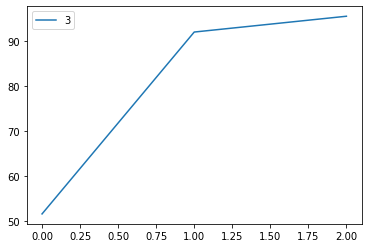

component=4
train score: 0.63500375
test score: 0.63516


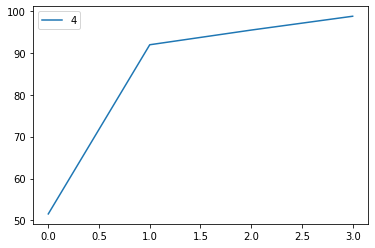

component=5
train score: 0.645888125
test score: 0.6459075


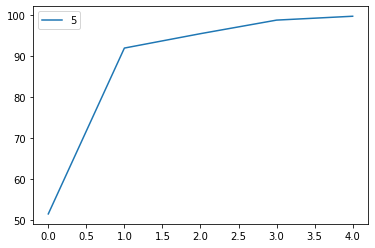

component=6
train score: 0.820274375
test score: 0.8204


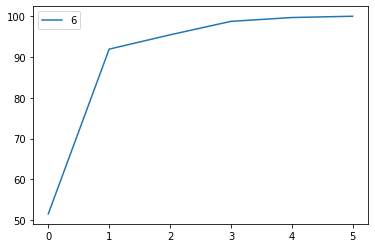

component=7
train score: 0.820485
test score: 0.820515


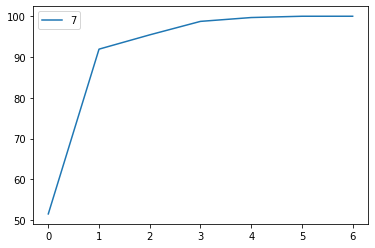

component=8
train score: 0.827725625
test score: 0.8277475


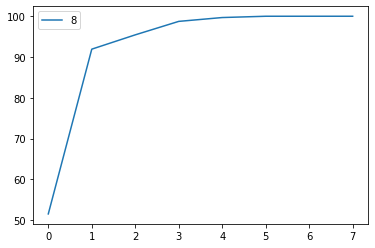

component=9
train score: 0.828579375
test score: 0.8285575


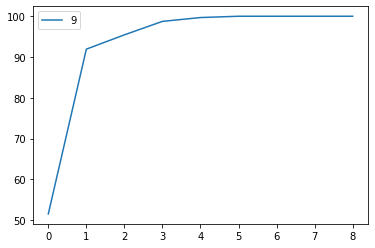

In [123]:
expl_var = []
n_components_list = range(3,10)
train_score_list = []
test_score_list = []
for n in n_components_list:
    print(f'component={n}')
    my_pca = PCA(n_components=n)
    my_pca.fit(X_train)
    X_train_PCA = my_pca.transform(X_train)
    X_test_PCA = my_pca.transform(X_test)
    train_score, test_score = OLS_test(X_train_PCA, X_test_PCA, y_train, y_test)
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    expl_var_cumulative = my_pca.explained_variance_ratio_.cumsum()*100
    expl_var.append(expl_var_cumulative)
    plt.figure()
    plt.plot(expl_var_cumulative, label=str(n))
    plt.legend()
    plt.show()

reducing dimension to 9 gives 82% accuracy, which is 4% less than no reduction

In [128]:
train_score_list

[array([[-8.96280421e+01, -2.09630241e+01,  2.40388146e+01, ...,
          1.31501591e-01,  3.37209287e-02,  2.56665669e-02],
        [-4.71144457e+01, -7.96687038e+01,  2.59704268e+01, ...,
         -4.49827526e-01,  7.85688413e-02, -2.37462817e-01],
        [ 2.00095791e+02,  1.84196151e+01,  4.30973622e+01, ...,
          1.72988475e-01,  4.60469107e-01,  1.27340402e-02],
        ...,
        [-1.23743464e+02,  4.81038857e+01,  2.74984805e+01, ...,
          2.37214516e-01,  8.28950112e-02,  5.64707465e-02],
        [-3.67759857e+00, -5.79167242e+01, -1.81221372e+01, ...,
          3.29453793e-01,  3.01055238e-01, -3.22279711e-01],
        [-6.82569700e+01, -3.41674301e+01, -1.15594645e+01, ...,
          4.79899217e-01,  1.10432821e-01, -1.62620348e-01]]),
 array([[-8.96280421e+01, -2.09630241e+01,  2.40388146e+01, ...,
          3.37209287e-02,  2.56665669e-02, -4.62640685e-02],
        [-4.71144457e+01, -7.96687038e+01,  2.59704268e+01, ...,
          7.85688413e-02, -2.37462817e

component=10
train score: 0.82852875
test score: 0.8285525


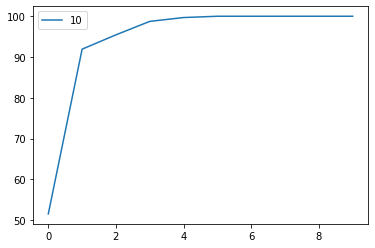

component=11
train score: 0.8286675
test score: 0.82865


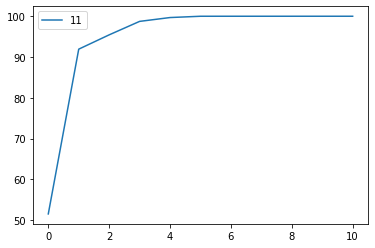

component=12
train score: 0.829336875
test score: 0.8292175


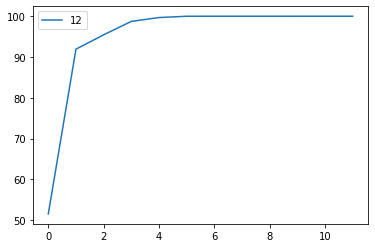

component=13
train score: 0.83202625
test score: 0.83161


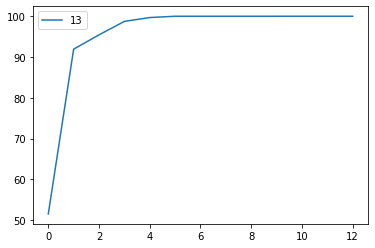

component=14


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.860528125
test score: 0.86031


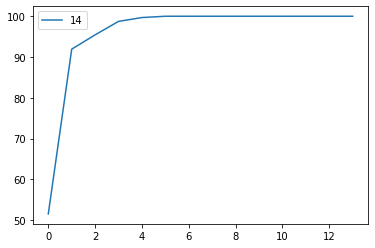

component=15


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.8606225
test score: 0.860115


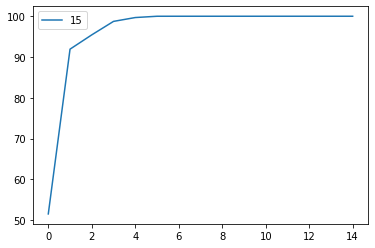

component=16


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.86232375
test score: 0.861555


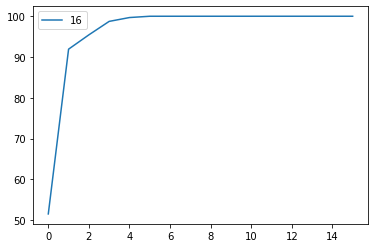

component=17


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.862399375
test score: 0.8614825


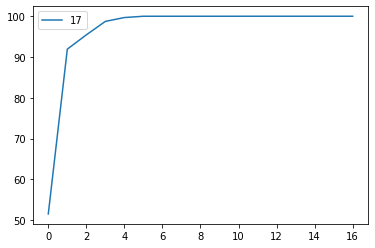

component=18


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.863750625
test score: 0.86315


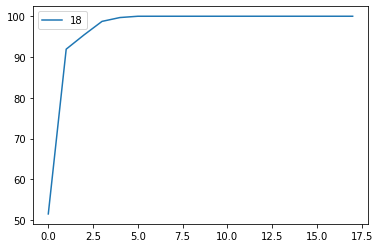

component=19


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.86496625
test score: 0.8645275


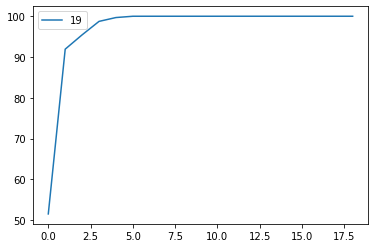

component=20


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score: 0.864595
test score: 0.86396


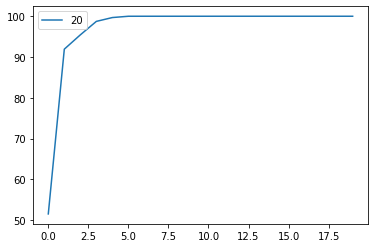

In [124]:
expl_var = []
n_components_list = range(10,21)
train_score_list = []
test_score_list = []
for n in n_components_list:
    print(f'component={n}')
    my_pca = PCA(n_components=n)
    my_pca.fit(X_train)
    X_train_PCA = my_pca.transform(X_train)
    X_test_PCA = my_pca.transform(X_test)
    train_score, test_score = OLS_test(X_train_PCA, X_test_PCA, y_train, y_test)
    train_score_list.append(X_train_PCA)
    test_score_list.append(test_score)
    expl_var_cumulative = my_pca.explained_variance_ratio_.cumsum()*100
    expl_var.append(expl_var_cumulative)
    plt.figure()
    plt.plot(expl_var_cumulative, label=str(n))
    plt.legend()
    plt.show()

Even to PCA component = 13, still does not give better results. This would only reduce the number of features by 21-3(time, persistence, orient)-13 = 5 features. 

At component 14, finally hit socre of 86%. This is reducing from 21-14 = 7 less features.

The benefit of PCA reducing components vs the negative of losing interpretability, I think don't use PCA.

Continue with dropping time, persistence and orient.

In [126]:
dir(NC)

['X',
 'X_test',
 'X_test_scaled',
 'X_train',
 'X_train_scaled',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data',
 'datapath',
 'loaddata',
 'mldata',
 'names',
 'pCapstone',
 'scaledata',
 'split_test_train',
 'transform',
 'transform_full',
 'y',
 'y_test',
 'y_train']

prior to this, Nutcracker.mldata outputs unscaled data. Now it's fixed. Also have put in standard feature reduction to remove time, persistence and orient

In [2]:
# check if the new code works
NC = Nutcracker(datapath)
# get machine learning input data
X_train, X_test, y_train, y_test = NC.mldata()
NC.names['X']

['area',
 'midline',
 'morphwidth',
 'width',
 'relwidth',
 'length',
 'rellength',
 'aspect',
 'relaspect',
 'kink',
 'curve',
 'speed',
 'angular',
 'bias',
 'dir',
 'vel_x',
 'vel_y',
 'crab']

In [4]:
len(NC.names['X'])

18

In [5]:
X_train.shape

(1600000, 18)

the feature reduction code has worked in Nutcracker.

In [6]:
pd.DataFrame(X_train, columns=NC.names['X'])

,area,midline,morphwidth,width,relwidth,length,rellength,aspect,relaspect,kink,curve,speed,angular,bias,dir,vel_x,vel_y,crab
0,-0.193703,-0.019687,0.181976,-0.280226,-0.176265,0.233162,0.047203,-0.387495,-0.243562,-0.902743,-1.074487,-1.088128,-0.434802,-1.376389,-0.093455,0.164037,-0.322082,-0.795098
1,-0.003490,0.530253,-0.703445,-0.954659,-1.202096,0.816957,0.465393,-0.960457,-1.001443,-0.431439,0.152201,0.626215,-0.492164,0.463606,-0.093455,0.728556,1.493708,-0.339314
2,1.535507,1.310711,0.855807,1.977656,1.044506,0.936370,0.683200,0.838007,0.352271,1.048045,-0.137018,-1.337154,-0.542356,-1.376389,-0.093455,-0.159121,-0.019562,-0.424111
3,-0.833511,-0.704526,-0.924800,0.540822,0.002696,-1.014036,0.169175,0.853923,-0.131376,0.650510,0.411501,-1.064537,-0.470654,0.463606,-0.093455,-0.171859,-0.336168,-0.609604
4,-1.006432,-0.278634,-1.588866,-1.277213,-1.505691,0.458719,0.735473,-1.119613,-1.255731,-1.119953,-1.902252,-1.124827,-0.112140,-1.376389,-0.093455,0.289411,0.141424,0.005173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,0.255891,0.425847,-0.263990,-0.074964,0.041045,0.564864,0.230161,-0.339748,-0.044120,-0.341277,-0.117072,0.924171,0.733953,0.463606,-0.093455,1.095964,1.541333,-0.334014
1599996,1.604675,0.694614,1.503597,0.247590,0.338248,0.047409,-0.858874,0.058142,0.384680,-0.566683,-1.772602,-1.371231,-0.484994,-1.376389,-0.093455,-0.006928,0.126667,-0.689102
1599997,-0.297456,0.024763,-0.280266,-0.602781,0.124134,0.684277,0.308572,-0.713765,-0.071544,-0.644551,-1.154271,-0.184647,-0.155161,0.463606,-0.093455,-1.015957,0.232650,-0.609604
1599998,0.740070,0.878099,-0.078442,-0.485488,0.942242,1.122123,0.596077,-0.721723,0.494374,-0.210131,-0.186883,1.573385,-0.262715,0.463606,-0.093455,2.133151,1.083864,0.418558


In [4]:
# try ols
from toolbox.datatransform import Nutcracker
NC = Nutcracker(datapath)
NC.mldata()
from brainstation_capstone.ml import LogisticRegression
LogisticRegression.quicktest(NC)

train score: 0.866989375
test score: 0.8665125


(0.866989375, 0.8665125, {})

In [5]:
from toolbox.datatransform import Nutcracker
NC_no_feature_reduction = Nutcracker(datapath)
NC_no_feature_reduction.mldata(feature_reduction='None')

from toolbox import LogisticRegression
LogisticRegression.quicktest(NC_no_feature_reduction)

train score: 0.866989375
test score: 0.8665125


(0.866989375, 0.8665125, {})

In [6]:
NC_no_feature_reduction.X_train.shape

(1600000, 18)

It's better off to keep all features for logistic regression. 